# Variational autoencoders

## What is a variational autoencoder (VAE)?

**Goal:** Enforce that for $x\sim p_X$ the samples $Encoder(x)=z$ look like Gaussian noise. I.e., we want 

$$p_Z \hat = \mathcal{N}(0, \sigma^2\mathbb{1}).$$

This would allow us to sample $z\sim \mathcal{N}(0, \sigma^2\mathbb{1})$ and compute $F(z)$ to general a random sample from $p_X$.


* To do that we will redefine the encoder as a probabilistic map

$$\mathcal{E}(x) \sim \mathcal{N}(\mu_E(x), \Sigma_E(x)).$$

* Why we do that will become apparent later.

* Reminder:

$$\mathcal{N}(\mu,\Sigma) = \frac{1}{\sqrt{(2\pi)^n \det(\Sigma)}}\exp -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)$$

This means that the entire autoencoder is now a probabilistic map $F\circ\mathcal{E}$.

### The Kullback-Leibler divergence
We begin by introducing the Kullback-Leibler (KL) divergence.

The KL divergence is a way to measure the distance between two probability distributions $p,q:\mathbb{R}^n\to\mathbb{R}_{\ge0}$. It is defined as

$$D_{KL}(q||p) = \mathbb{E}_{x\sim q} \log \frac{q(x)}{p(x)}$$

$$= \mathbb{E}_{x\sim q} [-\log p(x)] - [-\log q(x)] = \int_{\mathbb{R}^n} q(x) \log \frac{q(x)}{p(x)} dx \ge 0.$$

```{note}
Intuitively it makes sense if one thinks of $-\log p(x)$ as how **surprised** $p$ would be if it had produced the sample $x$ -- this is actually the formal definition of surprise in information theory. So $D_{KL}(q||p)$ answers the question: On average, how much more surprised is $p$ than $q$ to see $q$'s samples.
```

For Gaussians with $\mu_i\in\mathbb{R}^k$ and $\Sigma_i\in\mathbb{R}^{k\times k}$, a short calculation shows that the KL divergence reduces to the "closed form"

$$D_{KL}\left(\mathcal{N}(\mu_1,\Sigma_1), \mathcal{N}(\mu_2,\Sigma_2)\right) = \frac{1}{2}\left(
\log\frac{\det\Sigma_2}{\det\Sigma_1} - k + \mbox{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)
\right).
$$

If we assume $\Sigma\ge 0$ to be a diagonal matrix, we have

$$
D_{KL}\left(\mathcal{N}(\mu,\Sigma)||\mathcal{N}(0,\mathbb{1})\right) = 
\frac{1}{2}
\sum_{i=1}^k \Sigma_{i,i} + \mu_i^2 - 1 - \log \Sigma_{i,i}
.
$$

### The Variational Autoencoder loss

* We will use $p_E(z|x)$ to denote the Gaussian probability density function of $\mathcal{E}(x)$.

We then define the loss as

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{x\in\mathcal{D}}  \mathbb{E}_{z\sim p_E(z|x)}\left[\frac{1}{2} \|x - F(z)\|_2^2\right] + \lambda D_{KL}\left(p_E(\cdot|x)||p_Z(\cdot)\right).$$

We require the "$\mathbb{E}_{z\sim p_E(z|x)}$," as the encoder now produces a whole distibution of samples not just one and we want it to work for all samples (on average). But apart from that we simply have an additional penalty term that encourages the output of the decoder to follow $p_Z$.

```{note}
There is a deeper different explanation why this loss makes sense, see, e.g., [here](https://arxiv.org/pdf/1907.08956v1.pdf).
```

If we now plug in our inital goal $p_Z\hat=\mathcal{N}(0,\mathbb{1})$, use $p_E(\cdot|x) \hat= \mathcal{N}(\mu_E(x), \Sigma_E(x))$, use the closed form of the KL divergence, and assume that $\Sigma_E$ is a diagonal matrix, then we get

$$
D_{KL}\left(p_E(\cdot|x)||p_Z(\cdot)\right) = 
\frac{1}{2}\left(
\sum_{i=1}^m \Sigma_E(x)_{i,i} + \mu_E(x)_i^2 - 1 - \log \Sigma_E(x)_{i,i}
\right).
$$

Will model the encoder

$$\mathcal{E}(x) \sim \mathcal{N}(\mu_E(x), \mbox{diag} \Sigma_E(x))$$

via the neural networks $\mu_E(x)\in\mathbb{R}^m$, and $\Sigma_E(x)\in\mathbb{R}^m$.

We can sample from / implement $\mathcal{E}$ via

$$\mu_E(x) + \Sigma_E(x)^{1/2} \odot \eta \sim \mathcal{E}(x)$$
reparametrization
where we sample $\eta\sim \mathcal{N}(0,\mathbb{1})$.

This is called the **reparametrization trick**.

### Example of a VAE

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import logging
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

logging.getLogger('matplotlib.font_manager').disabled = True
plt.xkcd()


train_data = MNIST(
    root = 'datasets',
    train = True,
    transform = ToTensor(),
    download = True,
)

valid_data = MNIST(
    root = 'datasets',
    train = False,
    transform = ToTensor()
)

print(f"Training data shape: {tuple(train_data.data.shape)}")
print(f"Valid data shape: {tuple(valid_data.data.shape)}")

Training data shape: (60000, 28, 28)
Valid data shape: (10000, 28, 28)


In [2]:
batch_size = 128

data_loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

data_loader_valid = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,
)

In [3]:
def plot_loss(losses_train, losses_train_fidelity, losses_train_penalty, losses_valid):
    plt.title("losses_train")
    plt.plot(losses_train, label="losses_train")
    plt.plot(losses_train_fidelity, label="losses_train_fidelity")
    plt.plot(losses_train_penalty, label="losses_train_penalty")
    plt.plot(
        np.linspace(0, len(losses_train)-1, len(losses_valid)),
        losses_valid,
        label="losses_valid"
    )

    plt.yscale("log")
    plt.legend()
    plt.show()

In [4]:
class UnFlatten(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape


    def forward(self, xs):
        return xs.reshape(len(xs), *self.shape)

In [5]:
decoder = nn.Sequential(
    nn.Linear(64, 8*7*7),
    nn.ReLU(),
    UnFlatten([8, 7, 7]),
    nn.LayerNorm(normalized_shape=[8, 7, 7]),

    nn.UpsamplingNearest2d(size=[14, 14]),
    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[8, 14, 14]),

    nn.UpsamplingNearest2d(size=[28, 28]),
    nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
    nn.Sigmoid(),
)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = self.get_encoder()


    def get_encoder(self):
        encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=[8, 14, 14]),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=[16, 7, 7]),
            nn.Flatten(),
            nn.Linear(16*7*7, 2 * 64),
        )
        return encoder


    def get_μ_and_Σ(self, xs):
        Eμ_and_Eσ = self.encoder(xs)
        length = Eμ_and_Eσ.shape[1]
        Eμ = Eμ_and_Eσ[:,:length//2]
        Eσ = Eμ_and_Eσ[:,length//2:]
        assert Eμ.shape == Eσ.shape, f"{Eμ.shape=}, {Eσ.shape=}"

        μ = Eμ
        # We use exp to make the result positive and because
        # it makes the computation of log Σ more stable.
        Σ = torch.exp(Eσ)
        return μ, Σ


    def get_latent_sample(self, μ, Σ):
        ηs = torch.randn_like(μ)
        σ = Σ**.5
        zs = μ + σ * ηs
        return zs


    def forward(self, xs, n_samples=1):
        μ, Σ = self.get_μ_and_Σ(xs)
        samples = [self.get_latent_sample(μ, Σ) for _ in range(n_samples)]
        return μ, Σ, samples


encoder = Encoder()

In [7]:
def get_KL_divergence_loss(μ, Σ):
    pre_sum = Σ + μ**2 - 1 - torch.log(Σ)

    pre_sum = pre_sum.view(pre_sum.shape[0], -1)
    KL_div = 0.5 * pre_sum.mean(dim=-1)

    assert KL_div.shape == (len(μ),), f"{KL_div.shape=}"
    return KL_div.mean()

In [8]:
criterion = nn.BCELoss()

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

n_latent_samples = 1
λ = .25
n_epochs = 32

losses_train = []
losses_train_fidelity = []
losses_train_penalty = []

losses_valid = []

In [9]:
for _ in tqdm(range(n_epochs)):
    encoder.train()
    decoder.train()
    for xs, ys in data_loader_train:
        μ, Σ, samples = encoder(xs, n_samples=n_latent_samples)

        sum_fidelity = 0
        for zs in samples:
            xs_hat = decoder(zs)
            sum_fidelity += criterion(xs_hat, xs)

        fidelity = sum_fidelity / len(samples)

        kl_penalty = λ * get_KL_divergence_loss(μ, Σ)
        loss = fidelity + kl_penalty
        losses_train.append(loss.item())
        losses_train_fidelity.append(fidelity.item())
        losses_train_penalty.append(kl_penalty.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    encoder.eval()
    decoder.eval()
    losses_valid_tmp = []
    for xs, ys in data_loader_valid:
        μ, Σ, samples = encoder(xs, n_samples=1)
        xs_hat = decoder(samples[0])
        kl_penalty = λ * get_KL_divergence_loss(μ, Σ)
        loss = fidelity + kl_penalty
        losses_valid_tmp.append(loss.item())

        losses_valid_tmp.append(loss.item())
    losses_valid.append(np.mean(losses_valid_tmp))

  0%|          | 0/32 [00:00<?, ?it/s]

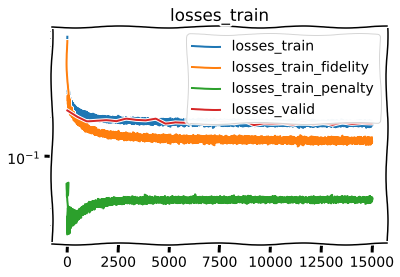

In [10]:
plot_loss(losses_train, losses_train_fidelity, losses_train_penalty, losses_valid)

In [11]:
def plot_reconstructions(encoder, decoder, xs=None):
    encoder.eval()
    decoder.eval()

    if xs is None:
        xs, ys = next(iter(data_loader_valid))

    μ, Σ, samples = encoder(xs, n_samples=1)
    xs_hat = decoder(samples[0])

    xs = xs.detach().cpu().numpy()
    xs_hat = xs_hat.detach().cpu().numpy()

    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.title("original")
        plt.imshow(xs[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, 8, 8 + i + 1)
        plt.title("output")
        plt.imshow(xs_hat[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 8)
    plt.tight_layout()
    plt.show()

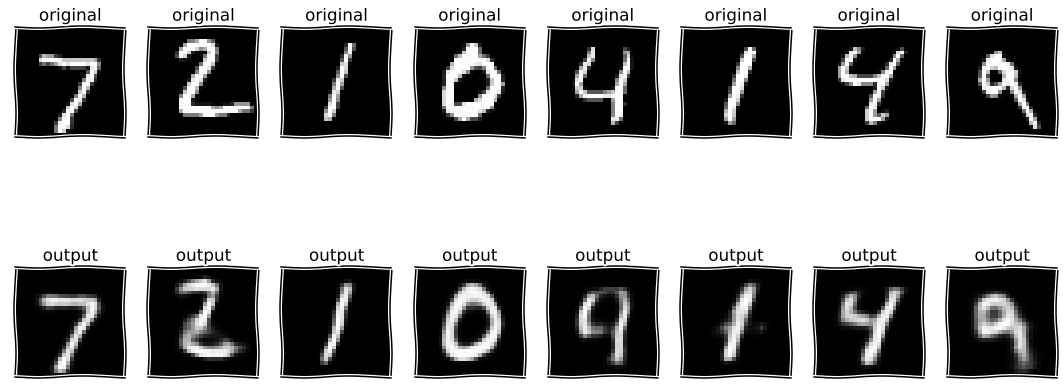

In [12]:
plot_reconstructions(encoder, decoder)

In [13]:
def plot_for_gaussian_random_samples(decoder):
    zs_mimic = torch.randn([8, 64])

    xs_mimic = decoder(zs_mimic).detach().cpu().numpy()

    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.title("mimic")
        plt.imshow(xs_mimic[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 3)
    plt.tight_layout()
    plt.show()

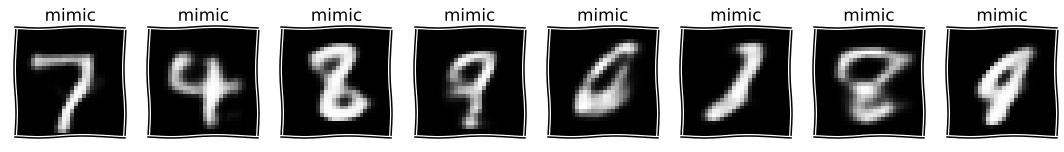

In [14]:
plot_for_gaussian_random_samples(decoder)

In [15]:
def plot_interpolations(decoder):
    xs, ys = next(iter(data_loader_valid))
    μ, Σ, samples = encoder(xs)
    zs = samples[0].detach().cpu().numpy()

    for sample_index in range(4):
        z_a = torch.tensor(zs[sample_index:sample_index+1], device=xs.device)
        z_b = torch.tensor(zs[sample_index+1:sample_index+2], device=xs.device)

        zs_mimic = []

        for α in np.linspace(0, 1, 8):
            z_mimic = (1 - α) * z_a + α * z_b
            zs_mimic.append(z_mimic)

        zs_mimic = torch.cat(zs_mimic)

        xs_mimic = decoder(zs_mimic).detach().cpu().numpy()

        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(xs_mimic[i].squeeze(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.gcf().set_size_inches(15, 3)
        plt.tight_layout()
        plt.show()

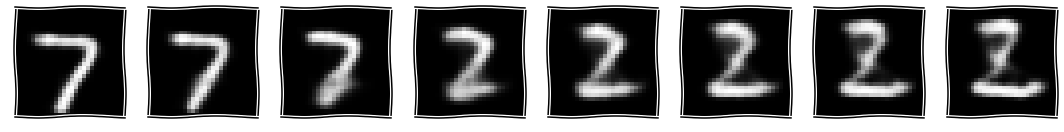

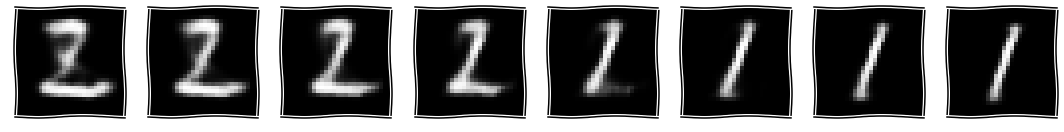

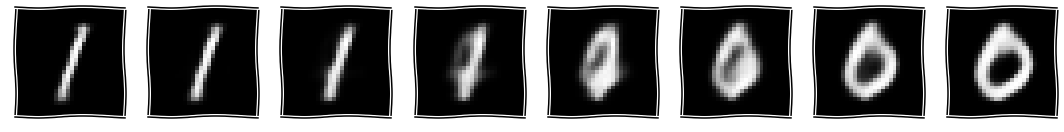

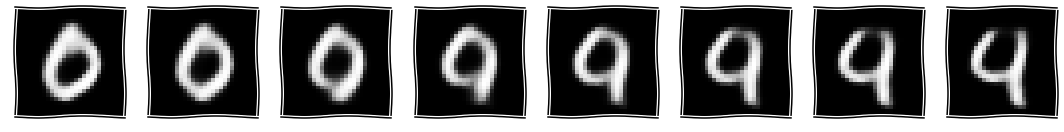

In [16]:
plot_interpolations(decoder)

* We can expect even better results if we train for longer and increase the size of the network.

## Conditional VAE (cVAE)

For the conditional VAE we make the loss and all parts of the model dependent on the label. This gives the network the context of what, in the case of MNIST, digit it is dealing with.

The regularization tries to squeeze out all information from $z$. Therefore, if we provide the label to the decoder, the training also tries to remove the now redundant label information from $z$.

The loss looks as the VAE loss, but with all models also reciving the label as an input. I.e., the loss reads

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{(x,y)\in\mathcal{D}}  \mathbb{E}_{z\sim p_E(z|x,y)}\left[\frac{1}{2} \|x - F(z,y)\|_2^2\right] + \lambda D_{KL}\left(p_E(\cdot|x,y)||p_Z(\cdot)\right).$$

Here the encoder is now

$$\mathcal{E}(x, y) = \mu_E(x,y) + \Sigma_E(x,y)^{1/2} \odot \eta $$

and the decoder

$$F:\mathbb{R}^k\times Y \ni (z, y) \mapsto \hat x(y) \in \mathbb{R}^n.$$


We will use a one-hot encoding for $y$ in the decoder, i.e., each label is represented as a vector of length 10 except for the $i$th entries being $1$ where $i$ is the label. For the Encoder we do the same but with $10$ additional input channels for the CNN. I.e., as we have 10 classes we add 10 channels to $x$ all of them zero, execpt for the $i$th channel that is one everywhere.

In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = self.get_decoder()


    def get_decoder(self):
        decoder = nn.Sequential(
            nn.Linear(64 + 10, 8*7*7),
            nn.ReLU(),
            UnFlatten([8, 7, 7]),
            nn.LayerNorm(normalized_shape=[8, 7, 7]),

            nn.UpsamplingNearest2d(size=[14, 14]),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=[8, 14, 14]),

            nn.UpsamplingNearest2d(size=[28, 28]),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
        return decoder


    def forward(self, zs, ys):
        one_hot_labels = torch.nn.functional.one_hot(ys, 10)
        zs_with_label = torch.cat([zs, one_hot_labels], dim=1)

        xs_hat = self.decoder(zs_with_label)
        return xs_hat


decoder = Decoder()

In [18]:
def get_one_hot_encoding(zs, ys):
    shape = list(zs.shape)
    shape[1] = 10

    ys_one_hot = torch.zeros(shape)
    assert len(ys) == len(zs)
    assert len(ys.shape) == 1, f"{ys.shape}"

    ys_one_hot[:, ys] = 1.
    return ys_one_hot

In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = self.get_encoder()


    def get_encoder(self):
        encoder = nn.Sequential(
            nn.Conv2d(in_channels=1+10, out_channels=8, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=[8, 14, 14]),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=[16, 7, 7]),
            nn.Flatten(),
            nn.Linear(16*7*7, 64 * 2),
        )
        return encoder


    def get_μ_and_Σ(self, xs, ys):
        ys = get_one_hot_encoding(xs, ys)
        Eμ_and_Eσ = self.encoder(torch.cat([xs, ys], dim=1))
        length = Eμ_and_Eσ.shape[1]
        Eμ = Eμ_and_Eσ[:,:length//2]
        Eσ = Eμ_and_Eσ[:,length//2:]
        assert Eμ.shape == Eσ.shape, f"{Eμ.shape=}, {Eσ.shape=}"

        μ = Eμ
        # We use exp to make the result positive and because
        # it makes the computation of log Σ more stable.
        Σ = torch.exp(Eσ)
        return μ, Σ


    def get_latent_sample(self, μ, Σ):
        ηs = torch.randn_like(μ)
        σ = Σ**.5
        zs = μ + σ * ηs
        return zs


    def forward(self, xs, ys, n_samples=1):
        μ, Σ = self.get_μ_and_Σ(xs, ys)
        samples = [self.get_latent_sample(μ, Σ) for _ in range(n_samples)]
        return μ, Σ, samples


encoder = Encoder()

In [20]:
criterion = nn.BCELoss()

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=3e-4)

n_latent_samples = 1
λ = .25
n_epochs = 32

losses_train = []
losses_valid = []

In [21]:
for _ in tqdm(range(n_epochs)):
    encoder.train()
    decoder.train()
    for xs, ys in data_loader_train:
        μ, Σ, samples = encoder(xs, ys, n_samples=n_latent_samples)

        sum_fidelity = 0
        for zs in samples:
            xs_hat = decoder(zs, ys)
            sum_fidelity += criterion(xs_hat, xs)

        fidelity = sum_fidelity / len(samples)

        kl_penalty = get_KL_divergence_loss(μ, Σ)
        loss = fidelity + λ * kl_penalty
        losses_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    encoder.eval()
    decoder.eval()
    losses_valid_tmp = []
    for xs, ys in data_loader_valid:
        μ, Σ, samples = encoder(xs, ys, n_samples=1)
        xs_hat = decoder(samples[0], ys)
        kl_penalty = get_KL_divergence_loss(μ, Σ)
        loss = fidelity + λ * kl_penalty
        losses_valid_tmp.append(loss.item())

        losses_valid_tmp.append(loss.item())
    losses_valid.append(np.mean(losses_valid_tmp))

  0%|          | 0/32 [00:00<?, ?it/s]

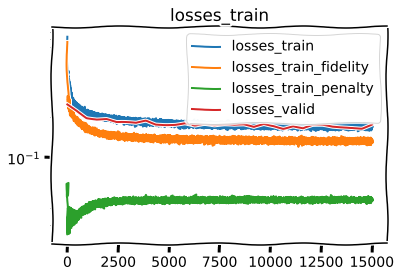

In [22]:
plot_loss(losses_train, losses_train_fidelity, losses_train_penalty, losses_valid)

In [23]:
def plot_reconstructions(encoder, decoder, xs=None):
    encoder.eval()
    decoder.eval()

    if xs is None:
        xs, ys = next(iter(data_loader_valid))

    μ, Σ, samples = encoder(xs, ys, n_samples=1)
    xs_hat = decoder(samples[0], ys)

    xs = xs.detach().cpu().numpy()
    xs_hat = xs_hat.detach().cpu().numpy()

    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.title("original")
        plt.imshow(xs[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, 8, 8 + i + 1)
        plt.title("output")
        plt.imshow(xs_hat[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 8)
    plt.tight_layout()
    plt.show()

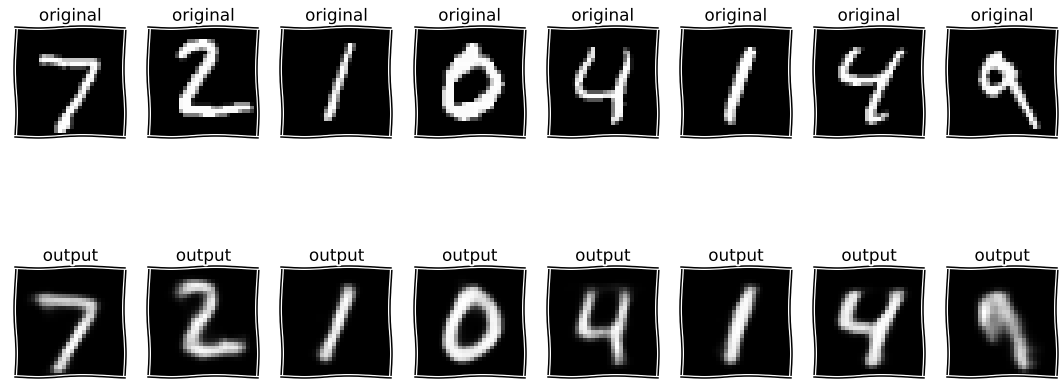

In [24]:
plot_reconstructions(encoder, decoder)

In [25]:
def plot_for_gaussian_random_samples(decoder, zs_mimic, label):
    ys = torch.ones(8, dtype=int) * label

    xs_mimic = decoder(zs_mimic, ys).detach().cpu().numpy()

    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.title("mimic")
        plt.imshow(xs_mimic[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 3)
    plt.tight_layout()
    plt.show()

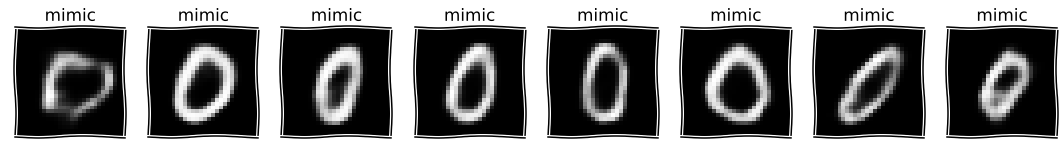

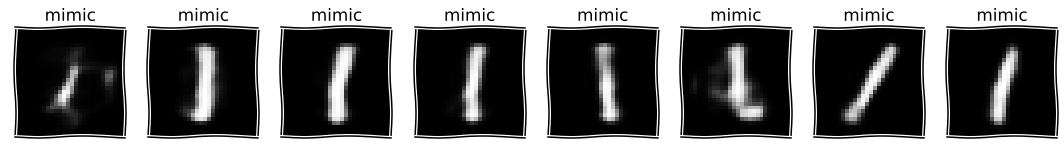

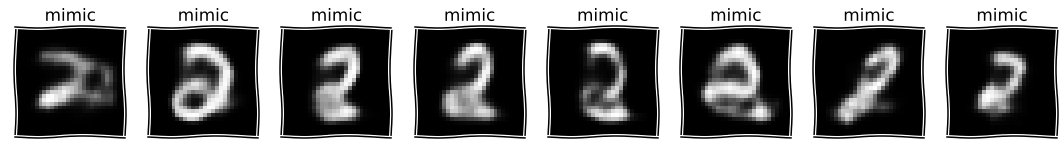

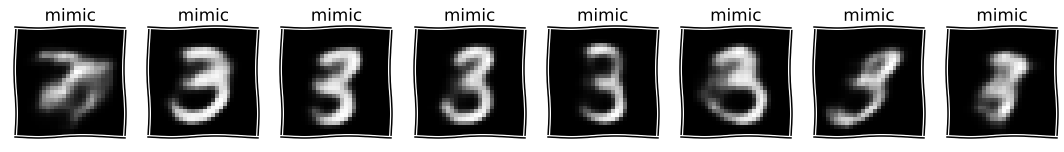

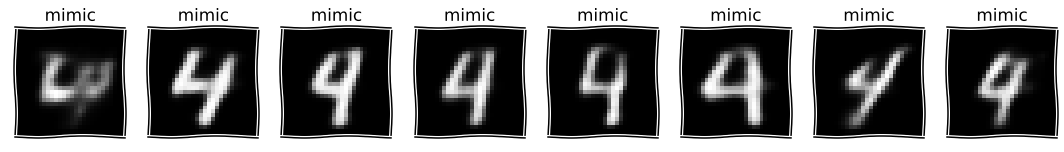

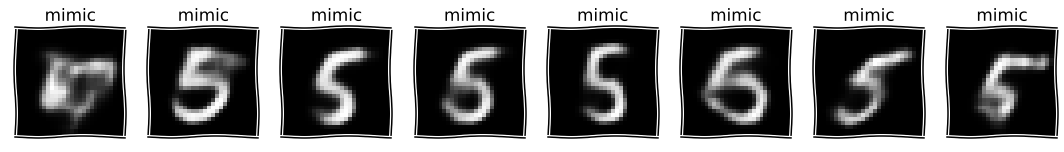

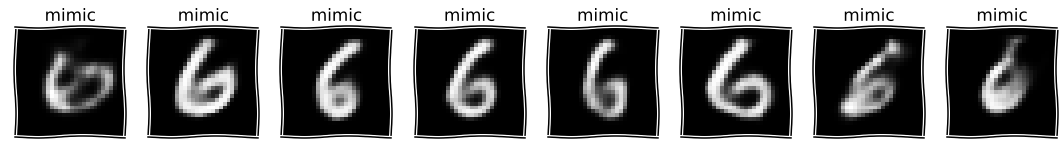

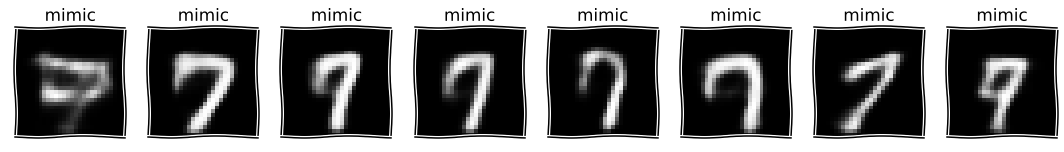

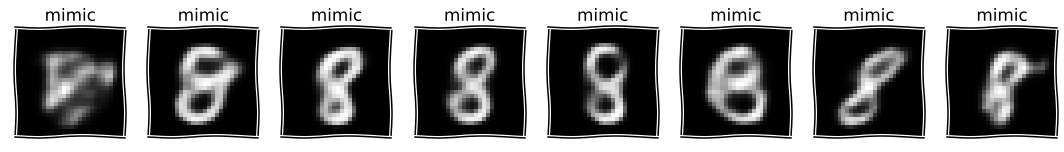

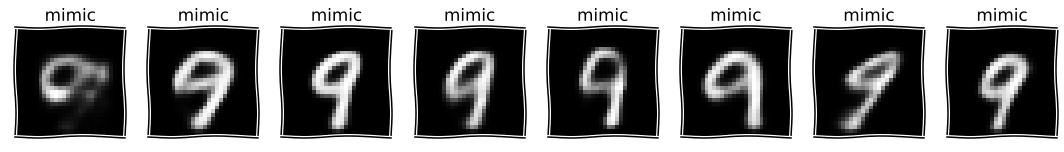

In [26]:
zs_mimic = torch.randn([8, 64])

for label in range(10):
    plot_for_gaussian_random_samples(decoder, zs_mimic, label)

* Again, we can expect even better results if we train for longer and increase the size of the network.